# Strapdown Demo --- Data paper and "Truth" generation

In this notebook we'll walk through how to use the strapdown binary for INS evaluation and GNSS denial and degredation simulation. To start, define some helper functions and ensure that the binary is compiled as a release verion.

In [71]:
!pixi run cargo build --workspace --release

⠁ activating environment                                                        warning: unused imports: `debug`, `info`, and `warn`
   --> core/src/strapdown.rs:123:11
    |
123 | use log::{debug, info, warn};
    |           ^^^^^  ^^^^  ^^^^
    |
    = note: `#[warn(unused_imports)]` (part of `#[warn(unused)]`) on by default

   --> core/src/sim.rs:908:22
    |
908 |                 let (mean, cov) = pf.compute_state();
    |                      ^^^^ help: if this is intentional, prefix it with an underscore: `_mean`
    |
    = note: `#[warn(unused_variables)]` (part of `#[warn(unused)]`) on by default

   --> core/src/sim.rs:908:28
    |
908 |                 let (mean, cov) = pf.compute_state();
    |                            ^^^ help: if this is intentional, prefix it with an underscore: `_cov`

   --> core/src/sim.rs:999:9
    |
999 |     let strategy = ParticleAveragingStrategy::WeightedAverage;
    |         ^^^^^^^^ help: if this is intentional, prefix it with an undersc

In [72]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from cartopy import crs as ccrs
from cartopy.io import img_tiles as cimgt
from haversine import Unit, haversine_vector
from matplotlib import pyplot as plt
from matplotlib.figure import Figure, SubFigure
from scipy.linalg import norm, sqrtm

ROOT = Path(".").resolve()


def find_strapdown_bin() -> Path:
    if "STRAPDOWN_BIN" in os.environ:
        return Path(os.environ["STRAPDOWN_BIN"])
    exe = "strapdown-sim.exe" if sys.platform.startswith("win") else "strapdown-sim"
    cand = Path().resolve().parents[1] / "target" / "release" / exe
    if cand.exists():
        return cand
    raise FileNotFoundError(
        "strapdown-sim not found. Build with `pixi run cargo build --workspace --release`."
    )


def plot_results(scenario: str, title_str: str = "") -> Figure | SubFigure:
    """Performance visualization plot helper"""
    truth = pd.read_csv(
        ROOT.joinpath("out", "baseline.csv"), index_col=0, parse_dates=True
    )
    df = pd.read_csv(
        ROOT.joinpath("out", f"{scenario}.csv"), index_col=0, parse_dates=True
    )
    truth_coords = truth[["latitude", "longitude", "altitude"]].copy().to_numpy()
    df_coords = df[["latitude", "longitude", "altitude"]].copy().to_numpy()

    two_d_error = haversine_vector(truth_coords[1:, :2], df_coords[1:, :2], Unit.METERS)
    time = (df.index - df.index[0]).total_seconds()
    plt.figure(figsize=(18, 6))
    plt.plot(time[1:], two_d_error)

    plt.xlim(left=0)
    plt.ylim((0, 150))

    plt.xlabel("Time (s)")
    plt.ylabel("Haversine Error (m)")
    plt.title(f"Simulation: {title_str}")
    # plt.legend()
    plt.grid()
    return plt.gcf()


def inflate_bounds(
    min_x: float, min_y: float, max_x: float, max_y: float, inflation_percent: float
) -> tuple[float, float, float, float]:
    width = max_x - min_x
    height = max_y - min_y
    if width <= 1e-6:
        width = 0.1
    if height <= 1e-6:
        height = 0.1
    inflate_x = width * inflation_percent
    inflate_y = height * inflation_percent
    new_min_x = min_x - inflate_x
    new_min_y = min_y - inflate_y
    new_max_x = max_x + inflate_x
    new_max_y = max_y + inflate_y
    return new_min_x, new_min_y, new_max_x, new_max_y


def plot_street_map(
    latitude: list[float], longitude: list[float], margin=0.01
) -> Figure:
    """
    Plots a street map using OpenStreetMap tiles.

    :param latitude: list of latitudes
    :type latitude: list[float]
    :param longitude: list of longitudes
    :type longitude: list[float]
    """
    # Define the map extent
    lat_min, lat_max = min(latitude), max(latitude)
    lon_min, lon_max = min(longitude), max(longitude)

    # Create a Stamen Terrain instance
    osm_tiles = cimgt.OSM()

    # Create a figure
    # Create a map using cartopy with OpenStreetMap background
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(
        [lon_min - margin, lon_max + margin, lat_min - margin, lat_max + margin],
        crs=ccrs.PlateCarree(),
    )  # type: ignore

    # Add the OSM tiles to the map
    ax.add_image(osm_tiles, 12)  # type: ignore

    # Plot the trajectory points
    ax.plot(longitude, latitude, "r.", transform=ccrs.PlateCarree())

    # Add gridlines with labels
    gl = ax.gridlines(draw_labels=True, alpha=0.2)  # type: ignore
    gl.top_labels = False
    gl.right_labels = False

    ax.set_title("Street Map with Trajectory Points", fontsize=16)

    return fig


def wasserstein2(
    mu1: np.ndarray, cov1: np.ndarray, mu2: np.ndarray, cov2: np.ndarray
) -> float:
    """Computes the 2-Wasserstein distance between two Gaussian distributions."""

    diff = norm(mu1 - mu2) ** 2
    trace = np.trace(cov1 + cov2 - 2 * sqrtm(sqrtm(cov2) @ cov1 @ sqrtm(cov2)))

    return diff + trace


def wasserstein2_vector(
    mu1s: np.ndarray, cov1s: np.ndarray, mu2s: np.ndarray, cov2s: np.ndarray
) -> np.ndarray:
    """Computes the 2-Wasserstein distance between two sequences of Gaussian distributions.

    Args:
        mu1s: Sequence of means for the first set of distributions. Shape (N, D)
        cov1s: Sequence of covariances for the first set of distributions. Shape (N, D, D)
        mu2s: Sequence of means for the second set of distributions. Shape (N, D)
        cov2s: Sequence of covariances for the second set of distributions. Shape (N, D, D)

    Returns:
        Array of 2-Wasserstein distances. Shape (N,)

    """
    diffs = np.linalg.norm(mu1s - mu2s, axis=1) ** 2
    traces = np.array(
        [
            np.trace(cov1 + cov2 - 2 * sqrtm(sqrtm(cov2) @ cov1 @ sqrtm(cov2)))
            for cov1, cov2 in zip(cov1s, cov2s)
        ]
    )
    return diffs + traces

Next we'll setup the output directory for saving off results.

In [73]:
ROOT.joinpath("out").mkdir(exist_ok=True)

## Truth

First we'll develop a baseline scenario with no GNSS degradation. This will serve as the "truth" scenario against which we can compare the degraded scenarios. Due to shell and environment variable management, we'll instead invoke the simulation from Python using subprocess.run(..) instead of relying on the shell directly (ie !strapdown-sim ...)

In [74]:
from subprocess import run

In [75]:
find_strapdown_bin()

PosixPath('/home/james/Code/strapdown-rs/target/release/strapdown-sim')

In [76]:
run(
    [
        find_strapdown_bin(),
        "closed-loop",
        "--input",
        ROOT.parents[1].joinpath("core", "tests", "test_data.csv"),
        "--output",
        "out/baseline.csv",
        "--sched",
        "passthrough",
        "--fault",
        "none",
        "--seed",
        "42",
        "--log-level",
        "info",
        "--log-file",
        "out/closed_loop.log",
    ],
    check=False,
)

Processing data 99.97%...

CompletedProcess(args=[PosixPath('/home/james/Code/strapdown-rs/target/release/strapdown-sim'), 'closed-loop', '--input', PosixPath('/home/james/Code/strapdown-rs/core/tests/test_data.csv'), '--output', 'out/baseline.csv', '--sched', 'passthrough', '--fault', 'none', '--seed', '42', '--log-level', 'info', '--log-file', 'out/closed_loop.log'], returncode=0)

In [77]:
gps = pd.read_csv(
    ROOT.parents[1].joinpath("core", "tests", "test_data.csv"),
    index_col=0,
    parse_dates=True,
)
nav = pd.read_csv(ROOT.joinpath("out", "baseline.csv"), index_col=0, parse_dates=True)

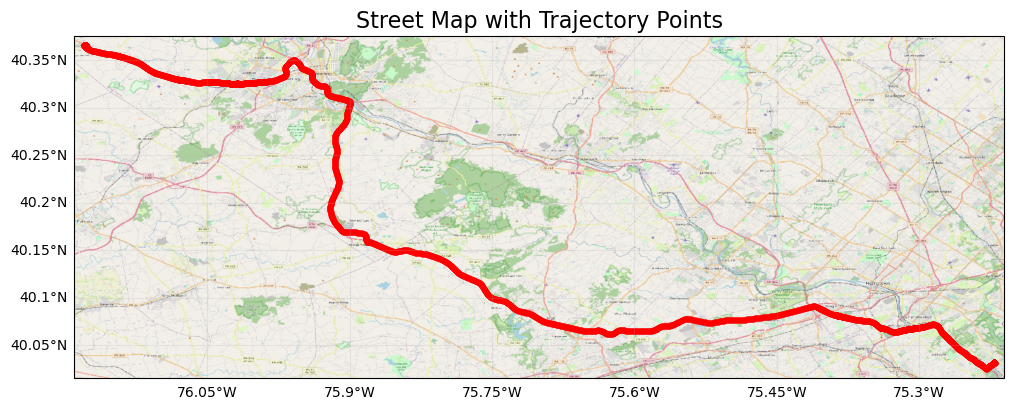

In [78]:
fig = plot_street_map(gps["latitude"].tolist(), gps["longitude"].tolist())
fig.savefig(ROOT.joinpath("out", "route_gps.png"), dpi=300)

In [79]:
nav[["latitude", "longitude", "latitude_cov", "longitude_cov"]]

,latitude,longitude,latitude_cov,longitude_cov
timestamp,,,,
2025-03-01 16:46:42+00:00,40.365658,-76.177651,1.017897e-06,1.017897e-06
2025-03-01 16:46:43+00:00,40.365652,-76.177610,1.017902e-06,1.017902e-06
2025-03-01 16:46:44+00:00,40.365636,-76.177568,1.017902e-06,1.017902e-06
2025-03-01 16:46:45+00:00,40.365614,-76.177532,1.017902e-06,1.017902e-06
2025-03-01 16:46:46+00:00,40.365594,-76.177502,1.017902e-06,1.017902e-06
...,...,...,...,...
2025-03-01 18:16:02+00:00,40.032168,-75.221509,1.017902e-06,1.017902e-06
2025-03-01 18:16:03+00:00,40.032168,-75.221509,1.017902e-06,1.017902e-06
2025-03-01 18:16:04+00:00,40.032168,-75.221508,1.017902e-06,1.017902e-06


In [80]:
certainty = nav[["latitude_cov", "longitude_cov"]].to_numpy()
certainty_m = haversine_vector(np.zeros_like(certainty), certainty, Unit.METERS)

In [81]:
gps_certainty = gps[["horizontalAccuracy", "verticalAccuracy"]].to_numpy()

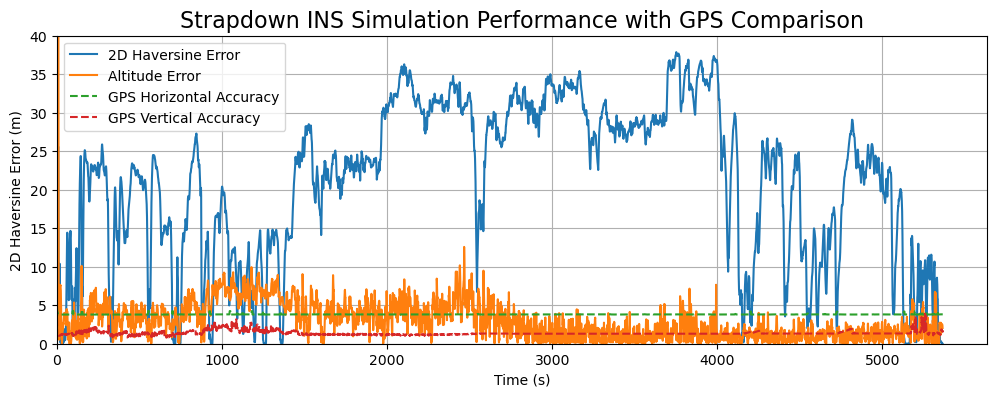

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
two_d_error = haversine_vector(
    gps[["latitude", "longitude"]].to_numpy()[1:, :],
    nav[["latitude", "longitude"]].to_numpy(),
    Unit.METERS,
)
ax.plot(
    (nav.index - nav.index[0]).total_seconds(), two_d_error, label="2D Haversine Error"
)
ax.plot(
    (nav.index - nav.index[0]).total_seconds(),
    abs(nav["altitude"].to_numpy() - gps["altitude"].to_numpy()[1:]),
    label="Altitude Error",
)

ax.plot(
    (gps.index - gps.index[0]).total_seconds(),
    gps["horizontalAccuracy"],
    label="GPS Horizontal Accuracy",
    linestyle="--",
)
ax.plot(
    (gps.index - gps.index[0]).total_seconds(),
    gps["verticalAccuracy"],
    label="GPS Vertical Accuracy",
    linestyle="--",
)
ax.set_xlim(left=0)
ax.set_ylim((0, 40))
ax.set_xlabel("Time (s)")
ax.set_ylabel("2D Haversine Error (m)")
ax.set_title("Strapdown INS Simulation Performance with GPS Comparison", fontsize=16)
ax.grid()
ax.legend()
plt.savefig(ROOT.joinpath("out", "performance.png"), dpi=300)

## Particle Filter Truth

In [84]:
run(
    [
        find_strapdown_bin(),
        "particle-filter",
        "-i",
        ROOT.parents[1].joinpath("core", "tests", "test_data.csv"),
        "-o",
        "out/pf.csv",
        "--num-particles",
        "10000",
        "--sched",
        "passthrough",
        "--fault",
        "none",
        "--seed",
        "42",
    ],
    check=False,
)

2025-12-01 17:22:44.299 [INFO] - Read 5366 records from /home/james/Code/strapdown-rs/core/tests/test_data.csv
2025-12-01 17:22:44.303 [INFO] - Initialized particle filter with 10000 particles
2025-12-01 17:22:44.306 [INFO] - Initial state mean: VecStorage { data: [0.7045134317577395, -1.3295513622013513, 92.84981763447651, -0.33486186222010556, 0.09785707661372472, 0.0, 0.1626282414793608, -1.339523780345961, 0.17920058593154986], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:44.306 [INFO] - Running particle filter with 10000 particles, strategy: WeightedAverage
2025-12-01 17:22:44.368 [INFO] - Particle filter state at 2025-03-01 16:46:43 UTC: VecStorage { data: [0.7045140604048304, -1.3295572796725397, 74.37895809397143, -10.559633448869068, 16.154835066505658, -18.51628536059098, 0.16953126116655262, -1.3418173429525995, 0.17977384449454942], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:44.408 [INFO] - Particle filter state at 2025-03-01 16:46:44 UTC: VecStorage { data: [0.704508

Processing data 0.06%...

2025-12-01 17:22:44.527 [INFO] - Particle filter state at 2025-03-01 16:46:47 UTC: VecStorage { data: [0.7044961724935374, -1.3295179042243863, -74.35854235510152, -30.662556945589404, 47.51765613454582, -55.73845150435044, 0.1684027267575561, -1.3395060609995142, 0.1792562727625054], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:44.562 [INFO] - Particle filter state at 2025-03-01 16:46:48 UTC: VecStorage { data: [0.7045070242986343, -1.3295098370901521, -134.75626055419562, -35.65069294748002, 55.40840522767197, -65.15182652115762, 0.16826061270796544, -1.3394236839601608, 0.17953394088475264], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:44.598 [INFO] - Particle filter state at 2025-03-01 16:46:49 UTC: VecStorage { data: [0.7045034254362834, -1.3295041148362228, -204.56544957125732, -40.738034996475406, 63.2652576699125, -74.5870449406057, 0.16828692629586614, -1.3392402138586215, 0.17953289873455552], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:44.633 [INFO] - Particle filter 

Processing data 0.19%...

2025-12-01 17:22:44.739 [INFO] - Particle filter state at 2025-03-01 16:46:53 UTC: VecStorage { data: [0.7044734791176105, -1.329444614188015, -577.6410688119392, -61.03012463781188, 94.61628502174584, -111.7499347949672, 0.17368018446280295, -1.3374496966514193, 0.17575908676553847], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:44.779 [INFO] - Particle filter state at 2025-03-01 16:46:54 UTC: VecStorage { data: [0.7044593600958051, -1.3294236912905464, -694.2365324372363, -65.98843916473425, 102.53156843769113, -121.15180587546254, 0.17351691521836515, -1.3379806420236409, 0.17534108490760128], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:44.816 [INFO] - Particle filter state at 2025-03-01 16:46:55 UTC: VecStorage { data: [0.7044483281863676, -1.3294221823183918, -819.9338650155182, -71.22768851080508, 110.2842318377557, -130.34133083696227, 0.17399353952891505, -1.3376076161958503, 0.1712233475002177], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:44.857 [INFO] - Particle filter

Processing data 0.31%...

2025-12-01 17:22:44.965 [INFO] - Particle filter state at 2025-03-01 16:46:59 UTC: VecStorage { data: [0.7044370248583559, -1.3294233421084771, -1414.897896603041, -91.9828101551336, 142.52390640776542, -167.28279480051467, 0.14545394586618626, -1.3199762611287311, 0.1998152559620371], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:45.001 [INFO] - Particle filter state at 2025-03-01 16:47:00 UTC: VecStorage { data: [0.7044396392872437, -1.32939321286727, -1586.8937825220517, -97.02641652534994, 150.38277896517863, -176.5866964033921, 0.14055935298532843, -1.3191609047983484, 0.20509647615842425], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:45.037 [INFO] - Particle filter state at 2025-03-01 16:47:01 UTC: VecStorage { data: [0.7044352520046879, -1.3293655607599455, -1767.86166122333, -102.18191445024422, 158.28237729434596, -185.8193644410998, 0.1409324625486977, -1.3180742260496994, 0.20179376842411229], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:45.078 [INFO] - Particle filter 

Processing data 0.43%...

2025-12-01 17:22:45.177 [INFO] - Particle filter state at 2025-03-01 16:47:05 UTC: VecStorage { data: [0.7044026214246565, -1.329254881337524, -2585.906567080383, -122.76431775136442, 189.51657670798875, -222.8790496604188, 0.1443727245186815, -1.31723359502576, 0.19898916620871476], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:45.212 [INFO] - Particle filter state at 2025-03-01 16:47:06 UTC: VecStorage { data: [0.7043866540119375, -1.3292218356064749, -2813.27975873834, -127.8490356294342, 197.38133989211954, -232.02019581488557, 0.14342147902767607, -1.3173342118101854, 0.199846120514445], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:45.245 [INFO] - Particle filter state at 2025-03-01 16:47:07 UTC: VecStorage { data: [0.7043689065862014, -1.329178115627034, -3050.205760599396, -132.8156301121018, 205.25588707586166, -241.5144340498184, 0.14600253339498317, -1.3167996684778012, 0.1980585817688638], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:45.278 [INFO] - Particle filter stat

Processing data 0.56%...

2025-12-01 17:22:45.383 [INFO] - Particle filter state at 2025-03-01 16:47:11 UTC: VecStorage { data: [0.7043001980944406, -1.3290598289027657, -4090.0676872456597, -153.3228296281598, 236.56125246504496, -278.4906867698973, 0.15190108057136614, -1.3159928682420452, 0.1936937469645803], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:45.416 [INFO] - Particle filter state at 2025-03-01 16:47:12 UTC: VecStorage { data: [0.7042765890628431, -1.3290207901756927, -4373.127009927464, -158.49364841026437, 244.3554065568036, -287.81035828038944, 0.15013136461674786, -1.3161476806470678, 0.19540376590161274], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:45.449 [INFO] - Particle filter state at 2025-03-01 16:47:13 UTC: VecStorage { data: [0.7042478376821165, -1.3289856238598827, -4665.523119219338, -163.4703404818396, 252.25215290550568, -297.01987817319946, 0.15184496204177136, -1.3160819365743457, 0.19411948581798139], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:45.482 [INFO] - Particle fi

Processing data 0.68%...

2025-12-01 17:22:45.585 [INFO] - Particle filter state at 2025-03-01 16:47:17 UTC: VecStorage { data: [0.7041258605284094, -1.3288379886627486, -5928.009463475013, -183.7918716051335, 283.6581145811537, -334.19955419683424, 0.15873727606595217, -1.316101077525776, 0.18893600643937516], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:45.620 [INFO] - Particle filter state at 2025-03-01 16:47:18 UTC: VecStorage { data: [0.7041140377256523, -1.3287921311797855, -6266.574351508697, -188.90288397997733, 291.58968508331367, -343.4320654802071, 0.1623538448093612, -1.3154432062072787, 0.18541663371710163], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:45.653 [INFO] - Particle filter state at 2025-03-01 16:47:19 UTC: VecStorage { data: [0.7040672491501159, -1.3287443000017558, -6614.575367423353, -194.09065909073902, 299.2682923041667, -352.5913273979216, 0.16240156669549255, -1.3153900174075246, 0.18463951323859693], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:45.685 [INFO] - Particle filte

Processing data 0.81%...

2025-12-01 17:22:45.794 [INFO] - Particle filter state at 2025-03-01 16:47:23 UTC: VecStorage { data: [0.7040045376790095, -1.3285811092207012, -8099.175106377672, -216.25035926174843, 330.429928901643, -389.76387651778487, 0.08763256721694161, -1.2838426402121224, 0.31395656138224076], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:45.827 [INFO] - Particle filter state at 2025-03-01 16:47:24 UTC: VecStorage { data: [0.7039772726727987, -1.3285500946139075, -8493.348188579816, -221.12326503762395, 338.80553124027915, -399.08067813837897, 0.08120574097032056, -1.273004915226014, 0.4152980535346878], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:45.862 [INFO] - Particle filter state at 2025-03-01 16:47:25 UTC: VecStorage { data: [0.7039425833920647, -1.3285027795400903, -8896.80042855966, -226.24237958840118, 346.6321558377967, -408.1557948755006, 0.01778847150440094, -1.2688016372239121, 0.5487044256256501], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:45.895 [INFO] - Particle filter

Processing data 0.93%...

2025-12-01 17:22:46.005 [INFO] - Particle filter state at 2025-03-01 16:47:29 UTC: VecStorage { data: [0.7038316358375356, -1.3283201309007533, -10604.140420071382, -247.033474911722, 378.9541961531777, -445.33468225973604, -0.028781753187092935, -0.9586524711215609, 0.4957869394822424], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:46.043 [INFO] - Particle filter state at 2025-03-01 16:47:30 UTC: VecStorage { data: [0.7038127307902199, -1.328254298341769, -11054.154700361885, -251.961504637572, 386.8630903359825, -454.5174713479469, -0.040970962011371466, -0.7904487346111213, 0.5127347976888378], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:46.079 [INFO] - Particle filter state at 2025-03-01 16:47:31 UTC: VecStorage { data: [0.7037800595766762, -1.3282101482722255, -11513.25812238685, -257.01797845143983, 395.0781376952289, -463.7544809366135, -0.04897378341854283, -0.6638721723982371, 0.5251042988278446], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:46.117 [INFO] - Particle filt

Processing data 1.06%...

2025-12-01 17:22:46.223 [INFO] - Particle filter state at 2025-03-01 16:47:35 UTC: VecStorage { data: [0.7037032972270209, -1.3279879150077891, -13444.408838096806, -277.673517336163, 427.8356932558298, -502.4207154736633, -0.04518612413227318, -0.28620136843348176, 0.5231265589581893], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:46.262 [INFO] - Particle filter state at 2025-03-01 16:47:36 UTC: VecStorage { data: [0.7036638248549695, -1.3279337187617744, -13952.063109128876, -283.22756612934637, 435.8274324717337, -513.1542936153996, -0.05122348468127695, 0.050307831846204, 0.5366695054262159], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:46.296 [INFO] - Particle filter state at 2025-03-01 16:47:37 UTC: VecStorage { data: [0.7036222257652114, -1.3278635708158604, -14470.518771838264, -288.25713771422875, 443.7532266228889, -523.8371013651109, -0.06232209954485106, 0.236884419855933, 0.5488619059657699], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:46.330 [INFO] - Particle filter

Processing data 1.18%...

2025-12-01 17:22:46.646 [INFO] - Particle filter state at 2025-03-01 16:47:47 UTC: VecStorage { data: [0.7032964410078902, -1.3271344898450386, -20183.127484261047, -346.70040561078827, 519.5017369427434, -616.1698623583986, 0.018122982755170672, 1.3642796751108823, 0.6884722137500326], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:46.685 [INFO] - Particle filter state at 2025-03-01 16:47:48 UTC: VecStorage { data: [0.7032559067846046, -1.327055955166058, -20803.22348535835, -352.63325265157437, 527.1721755245404, -624.2903087699083, 0.506150896506362, 1.5265964353335333, 1.1859558514695043], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:46.722 [INFO] - Particle filter state at 2025-03-01 16:47:49 UTC: VecStorage { data: [0.7032208727500296, -1.326980997573923, -21431.77181255863, -358.3892777012127, 534.9141388792672, -632.796544741454, 2.698022698165749, 1.4789959177254608, -2.893149494537952], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:46.760 [INFO] - Particle filter state at 

Processing data 1.30%...

2025-12-01 17:22:46.864 [INFO] - Particle filter state at 2025-03-01 16:47:53 UTC: VecStorage { data: [0.7030324956036613, -1.326659440520318, -24028.448623120556, -380.08968650964295, 566.4084774324773, -665.0007006256684, 2.9288241432315454, 0.9100465701189481, -2.6035786572149457], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:46.903 [INFO] - Particle filter state at 2025-03-01 16:47:54 UTC: VecStorage { data: [0.703001308351241, -1.326579859183032, -24697.43605191078, -385.37476741293546, 574.6361581086328, -672.929428186281, 2.937469598278575, 0.7581860342705219, -2.591252910253178], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:46.944 [INFO] - Particle filter state at 2025-03-01 16:47:55 UTC: VecStorage { data: [0.7029663530530524, -1.3264886029880065, -25374.256295900836, -390.7497167185587, 582.7772048001743, -681.1700070655424, 2.958594886074718, 0.6851646629433543, -2.586034902004605], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:46.979 [INFO] - Particle filter state at 2

Processing data 1.43%...

2025-12-01 17:22:47.085 [INFO] - Particle filter state at 2025-03-01 16:47:59 UTC: VecStorage { data: [0.7027828003374182, -1.3261171546603439, -28168.942386695846, -409.6381869322266, 617.2590828720062, -716.3697443924119, 2.9785468319311366, 0.30023193910844415, -2.5843589764112243], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:47.126 [INFO] - Particle filter state at 2025-03-01 16:48:00 UTC: VecStorage { data: [0.7027352874666827, -1.3260261662851878, -28889.58531341755, -413.7259846029581, 626.081058362878, -725.1924935827617, 2.9983940480908853, 0.10638904626939459, -2.5765775247756606], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:47.169 [INFO] - Particle filter state at 2025-03-01 16:48:01 UTC: VecStorage { data: [0.7027013307161054, -1.3259182577794908, -29619.034366104708, -417.98919883724415, 634.8800359576402, -734.03415092425, 3.0185836729616797, -0.07161525206006841, -2.559372525609531], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:47.212 [INFO] - Particle filter sta

Processing data 1.55%...

2025-12-01 17:22:47.320 [INFO] - Particle filter state at 2025-03-01 16:48:05 UTC: VecStorage { data: [0.7025001680000452, -1.3255045660447076, -32629.847429760008, -435.77281799781434, 669.2957250959254, -772.0644185664969, 2.9818793004751187, -0.6980457856693826, -2.4889136286654745], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:47.360 [INFO] - Particle filter state at 2025-03-01 16:48:06 UTC: VecStorage { data: [0.7024454679632435, -1.3253901365195448, -33406.5997082849, -440.81239896962904, 677.5501313253459, -781.9865850598479, 2.9643593470197542, -0.8179799372902823, -2.470708755013124], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:47.395 [INFO] - Particle filter state at 2025-03-01 16:48:07 UTC: VecStorage { data: [0.7023850400135494, -1.325287770327257, -34193.14250155344, -446.94775244908755, 685.1950976922266, -791.2835568883467, 2.9777415526063638, -0.7663943953665607, -2.490725333883596], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:47.446 [INFO] - Particle filter sta

Processing data 1.62%...

2025-12-01 17:22:47.585 [INFO] - Particle filter state at 2025-03-01 16:48:10 UTC: VecStorage { data: [0.7022441990974789, -1.3249376719753299, -36609.25631168419, -468.63302621968415, 705.0995221044028, -820.534898839968, 2.9788173483617286, 0.34976731824398843, -2.5549464357160465], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:47.648 [INFO] - Particle filter state at 2025-03-01 16:48:11 UTC: VecStorage { data: [0.7021770005104683, -1.3248332383586925, -37434.76061454427, -475.1415876546262, 711.9747975930296, -830.3918144518036, 2.9359900522470714, 0.6610227240989167, -2.582286351612769], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:47.704 [INFO] - Particle filter state at 2025-03-01 16:48:12 UTC: VecStorage { data: [0.7021092998294031, -1.3247163205452137, -38269.7174720701, -480.8162797860905, 719.4740144932953, -839.9120316326711, 2.8983224200319975, 0.8008668261524872, -2.609123549433058], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:47.768 [INFO] - Particle filter state at

Processing data 1.68%...

2025-12-01 17:22:47.826 [INFO] - Particle filter state at 2025-03-01 16:48:14 UTC: VecStorage { data: [0.7019895508524583, -1.3244806089034384, -39970.716331227915, -487.18449571277455, 738.7452026640456, -860.8680798509178, 2.8889266114195524, 0.8149565689603443, -2.62900848324576], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:47.880 [INFO] - Particle filter state at 2025-03-01 16:48:15 UTC: VecStorage { data: [0.7019171999143881, -1.3243594577063227, -40836.10556298003, -491.9838981368633, 747.2318105729116, -870.3166288461581, 2.893150270585873, 0.8164620040262981, -2.6336260889607552], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:47.927 [INFO] - Particle filter state at 2025-03-01 16:48:16 UTC: VecStorage { data: [0.7018611830825442, -1.3242393133299442, -41711.26307938574, -497.2991771108277, 755.2263916451917, -879.6932311436719, 2.894062334277702, 0.8166616900000606, -2.6337888750027347], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:47.962 [INFO] - Particle filter state at

Processing data 1.80%...

2025-12-01 17:22:48.038 [INFO] - Particle filter state at 2025-03-01 16:48:19 UTC: VecStorage { data: [0.7016732904185564, -1.3238506253501017, -44388.01534187896, -515.8097078090498, 776.8830728207804, -904.6042532387403, 2.8964640504467134, 0.6375931526860125, -2.624148767775848], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:48.074 [INFO] - Particle filter state at 2025-03-01 16:48:20 UTC: VecStorage { data: [0.7016075741195555, -1.3237307610594433, -45297.43858652842, -522.7213537303414, 783.4406899160749, -913.949018176268, 2.8599145864777653, 0.7990633737982412, -2.6763084212759667], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:48.112 [INFO] - Particle filter state at 2025-03-01 16:48:21 UTC: VecStorage { data: [0.7015268295653618, -1.3236040338881256, -46216.12636238583, -528.6455842717731, 790.9814179789381, -923.5324222510824, 2.8453613037219925, 0.9137800263483706, -2.690310000255011], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:48.148 [INFO] - Particle filter state at 

Processing data 1.93%...

2025-12-01 17:22:48.263 [INFO] - Particle filter state at 2025-03-01 16:48:25 UTC: VecStorage { data: [0.7012719603984797, -1.323039152405203, -49986.23537895244, -546.8795011750722, 825.5595205623271, -962.3459006350047, 2.915180923917887, 0.9918706841740103, -2.6234318504560368], nrows: Dyn(9), ncols: Const }
2025-12-01 17:22:48.302 [ERROR] - Health fail after propagate at 2025-03-01 16:48:26 UTC (#312): Altitude out of range: -50953.24043483026 m
2025-12-01 17:22:48.302 [ERROR] - Error running particle filter simulation: Altitude out of range: -50953.24043483026 m


CompletedProcess(args=[PosixPath('/home/james/Code/strapdown-rs/target/release/strapdown-sim'), 'particle-filter', '-i', PosixPath('/home/james/Code/strapdown-rs/core/tests/test_data.csv'), '-o', 'out/pf.csv', '--num-particles', '10000', '--sched', 'passthrough', '--fault', 'none', '--seed', '42'], returncode=0)

In [ ]:
gps = pd.read_csv(
    ROOT.parents[1].joinpath("sim", "data", "test_data.csv"),
    index_col=0,
    parse_dates=True,
)
nav = pd.read_csv(ROOT.joinpath("out", "baseline.csv"), index_col=0, parse_dates=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
two_d_error = haversine_vector(
    gps[["latitude", "longitude"]].to_numpy()[1:, :],
    nav[["latitude", "longitude"]].to_numpy(),
    Unit.METERS,
)
ax.plot(
    (nav.index - nav.index[0]).total_seconds(), two_d_error, label="2D Haversine Error"
)
ax.plot(
    (nav.index - nav.index[0]).total_seconds(),
    abs(nav["altitude"].to_numpy() - gps["altitude"].to_numpy()[1:]),
    label="Altitude Error",
)
ax.plot(
    (gps.index - gps.index[0]).total_seconds(),
    gps["horizontalAccuracy"],
    label="GPS Horizontal Accuracy",
    linestyle="--",
)
ax.plot(
    (gps.index - gps.index[0]).total_seconds(),
    gps["verticalAccuracy"],
    label="GPS Vertical Accuracy",
    linestyle="--",
)
ax.set_xlim(left=0)
ax.set_ylim((0, 40))
ax.set_xlabel("Time (s)")
ax.set_ylabel("2D Haversine Error (m)")
ax.set_title("Strapdown INS Simulation Performance with GPS Comparison", fontsize=16)
ax.grid()
ax.legend()
plt.savefig(ROOT.joinpath("out", "performance.png"), dpi=300)

## Individual fault models

This section runs a test case example for each type of built in fault model.

### Degraded (AR(1)) @ full GNSS rate

Expect: smooth horizontal wander (few meters), velocity slightly noisy; innovations/NIS stay reasonable because R is inflated by r_scale.

In [ ]:
run(
    [
        find_strapdown_bin(),
        "-i",
        ROOT.parents[1].joinpath("sim", "data", "test_data.csv"),
        "-o",
        "out/degraded_fullrate.csv",
        "closed-loop",
        "--sched",
        "passthrough",
        "--fault",
        "degraded",
        "--rho-pos",
        "0.99",
        "--sigma-pos-m",
        "3",
        "--rho-vel",
        "0.95",
        "--sigma-vel-mps",
        "0.3",
        "--r-scale",
        "5",
        "--seed",
        "42",
    ]
)
fig = plot_results("degraded_fullrate", "Degraded")
fig.savefig(ROOT.joinpath("out", "degraded_fullrate_performance.png"), dpi=300)

### Degraded (AR(1)) + reduced GNSS
Expect: “sawtooth” position error between fixes; RMS often 10–30 m depending on motion.

In [ ]:
run(
    [
        find_strapdown_bin(),
        "-i",
        ROOT.parents[1].joinpath("sim", "data", "test_data.csv"),
        "-o",
        "out/degraded.csv",
        "closed-loop",
        "--sched",
        "fixed",
        "--interval-s",
        "5",
        "--fault",
        "degraded",
        "--rho-pos",
        "0.99",
        "--sigma-pos-m",
        "3",
        "--rho-vel",
        "0.95",
        "--sigma-vel-mps",
        "0.3",
        "--r-scale",
        "5",
        "--seed",
        "42",
    ]
)

fig = plot_results("degraded", "Degraded with 5s GPS")
fig.savefig(ROOT.joinpath("out", "degraded_performance.png"), dpi=300)

### SlowBias (soft spoof) @ 1 Hz GNSS

Expect: steady north drift (~2 cm/s); lat/lon error grows roughly linearly with time; velocities biased by (0.02, 0.0) m/s.

In [ ]:
run(
    [
        find_strapdown_bin(),
        "-i",
        ROOT.parents[1].joinpath("sim", "data", "test_data.csv"),
        "-o",
        "out/slowbias.csv",
        "closed-loop",
        "--sched",
        "passthrough",
        "--fault",
        "slowbias",
        "--drift-n-mps",
        "0.02",
        "--drift-e-mps",
        "0.00",
        "--q-bias",
        "1e-6",
        "--rotate-omega-rps",
        "0.0",
        "--seed",
        "42",
    ]
)

fig = plot_results("slowbias", "Slow Bias")
fig.savefig(ROOT.joinpath("out", "slowbias_performance.png"), dpi=300)

### SlowBias with slow rotation (soft curved spoof)

Expect: drift direction slowly rotates (~0.057°/s); lateral error forms an arc.

In [ ]:
run(
    [
        find_strapdown_bin(),
        "-i",
        ROOT.parents[1].joinpath("sim", "data", "test_data.csv"),
        "-o",
        "out/slowbias_rot.csv",
        "closed-loop",
        "--sched",
        "passthrough",
        "--fault",
        "slowbias",
        "--drift-n-mps",
        "0.02",
        "--drift-e-mps",
        "0.00",
        "--q-bias",
        "5e-6",
        "--rotate-omega-rps",
        "1e-3",
        "--seed",
        "42",
    ]
)

fig = plot_results("slowbias_rot", "Slow Bias with Rotation")
fig.savefig(ROOT.joinpath("out", "slowbias_rot_performance.png"), dpi=300)

### Hijack (hard offset) 

A spoofing attack occurs for a 60 second window starting at t=120 seconds

Expect: abrupt ~50 m north offset only inside [120, 180] s; returns to nominal after.

In [ ]:
run(
    [
        find_strapdown_bin(),
        "-i",
        ROOT.parents[1].joinpath("sim", "data", "test_data.csv"),
        "-o",
        "out/hijack.csv",
        "closed-loop",
        "--sched",
        "passthrough",
        "--fault",
        "hijack",
        "--hijack-start-s",
        "120",
        "--hijack-duration-s",
        "60",
        "--hijack-offset-n-m",
        "50",
        "--hijack-offset-e-m",
        "0",
        "--seed",
        "42",
    ]
)

fig = plot_results("hijack", "Hijack")
fig.savefig(ROOT.joinpath("out", "hijack_performance.png"), dpi=300)

## Scheduler-only effects 

These fault conditions only concern the *availability* of GNSS signals. The signal itself is not corrupted just intermittently or periodically unavailable or provided at a much reduced rate.

### Reduced rate only, no fault

Expect: INS drift between fixes; error clamps at each 10 s update.

In [ ]:
run(
    [
        find_strapdown_bin(),
        "-i",
        ROOT.parents[1].joinpath("sim", "data", "test_data.csv"),
        "-o",
        "out/sched.csv",
        "closed-loop",
        "--sched",
        "fixed",
        "--interval-s",
        "10",
        "--fault",
        "none",
        "--seed",
        "42",
    ]
)

fig = plot_results("sched", "Fixed 10s Interval")
fig.savefig(ROOT.joinpath("out", "sched_performance.png"), dpi=300)

### Duty-cycle outages

Expect: growing error during OFF windows; recovery during ON; repeat.

In [ ]:
run(
    [
        find_strapdown_bin(),
        "-i",
        ROOT.parents[1].joinpath("sim", "data", "test_data.csv"),
        "-o",
        "out/duty.csv",
        "closed-loop",
        "--sched",
        "duty",
        "--on-s",
        "10",
        "--off-s",
        "2",
        "--duty-phase-s",
        "1",
        "--fault",
        "none",
        "--seed",
        "42",
    ]
)

fig = plot_results("duty", "Fixed 10s On, 2s Off")
fig.savefig(ROOT.joinpath("out", "duty_performance.png"), dpi=300)

## Combination Scenarios

Degraded + SlowBias (soft spoof under poor SNR) + 10 s rate

In [ ]:
run(
    [
        find_strapdown_bin(),
        "-i",
        ROOT.parents[1].joinpath("sim", "data", "test_data.csv"),
        "-o",
        "out/combo.csv",
        "closed-loop",
        "--sched",
        "fixed",
        "--interval-s",
        "5",
        "--fault",
        "degraded",
        "--rho-pos",
        "0.995",
        "--sigma-pos-m",
        "4",
        "--rho-vel",
        "0.97",
        "--sigma-vel-mps",
        "0.35",
        "--r-scale",
        "5",
        "--seed",
        "42",
    ]
)

fig = plot_results("combo", "Combination of Degraded and 5s GPS")
fig.savefig(ROOT.joinpath("out", "combo_performance.png"), dpi=300)

### Duty-cycle outages + Hijack window (stress)

Expect: large jumps inside hijack window, plus drift during OFF periods.

In [ ]:
run(
    [
        find_strapdown_bin(),
        "-i",
        ROOT.parents[1].joinpath("sim", "data", "test_data.csv"),
        "-o",
        "out/combo_duty_hijack.csv",
        "closed-loop",
        "--sched",
        "duty",
        "--on-s",
        "10",
        "--off-s",
        "3",
        "--duty-phase-s",
        "0",
        "--fault",
        "hijack",
        "--hijack-start-s",
        "150",
        "--hijack-duration-s",
        "120",
        "--hijack-offset-n-m",
        "10",
        "--hijack-offset-e-m",
        "10",
        "--seed",
        "42",
    ]
)

fig = plot_results("combo_duty_hijack", "Combination of Duty Cycle and Hijack")
fig.savefig(ROOT.joinpath("out", "combo_duty_hijack_performance.png"), dpi=300)

In [ ]:
combo_duty_hijack = pd.read_csv(
    ROOT.joinpath("out", "combo_duty_hijack.csv"), index_col=0, parse_dates=True
)
combo = pd.read_csv(ROOT.joinpath("out", "combo.csv"), index_col=0, parse_dates=True)
degraded_fullrate = pd.read_csv(
    ROOT.joinpath("out", "degraded_fullrate.csv"), index_col=0, parse_dates=True
)
degraded = pd.read_csv(
    ROOT.joinpath("out", "degraded.csv"), index_col=0, parse_dates=True
)
slowbias = pd.read_csv(
    ROOT.joinpath("out", "slowbias.csv"), index_col=0, parse_dates=True
)
slowbias_rot = pd.read_csv(
    ROOT.joinpath("out", "slowbias_rot.csv"), index_col=0, parse_dates=True
)
hijack = pd.read_csv(ROOT.joinpath("out", "hijack.csv"), index_col=0, parse_dates=True)
sched = pd.read_csv(ROOT.joinpath("out", "sched.csv"), index_col=0, parse_dates=True)
duty = pd.read_csv(ROOT.joinpath("out", "duty.csv"), index_col=0, parse_dates=True)
baseline = pd.read_csv(
    ROOT.joinpath("out", "baseline.csv"), index_col=0, parse_dates=True
)

combo_duty_hijack_error = haversine_vector(
    nav[["latitude", "longitude"]].to_numpy(),
    combo_duty_hijack[["latitude", "longitude"]].to_numpy(),
    Unit.METERS,
)
combo_error = haversine_vector(
    nav[["latitude", "longitude"]].to_numpy(),
    combo[["latitude", "longitude"]].to_numpy(),
    Unit.METERS,
)
degraded_fullrate_error = haversine_vector(
    nav[["latitude", "longitude"]].to_numpy(),
    degraded_fullrate[["latitude", "longitude"]].to_numpy(),
    Unit.METERS,
)
degraded_error = haversine_vector(
    nav[["latitude", "longitude"]].to_numpy(),
    degraded[["latitude", "longitude"]].to_numpy(),
    Unit.METERS,
)
slowbias_error = haversine_vector(
    nav[["latitude", "longitude"]].to_numpy(),
    slowbias[["latitude", "longitude"]].to_numpy(),
    Unit.METERS,
)
slowbias_rot_error = haversine_vector(
    nav[["latitude", "longitude"]].to_numpy(),
    slowbias_rot[["latitude", "longitude"]].to_numpy(),
    Unit.METERS,
)
hijack_error = haversine_vector(
    nav[["latitude", "longitude"]].to_numpy(),
    hijack[["latitude", "longitude"]].to_numpy(),
    Unit.METERS,
)
sched_error = haversine_vector(
    nav[["latitude", "longitude"]].to_numpy(),
    sched[["latitude", "longitude"]].to_numpy(),
    Unit.METERS,
)
duty_error = haversine_vector(
    nav[["latitude", "longitude"]].to_numpy(),
    duty[["latitude", "longitude"]].to_numpy(),
    Unit.METERS,
)

# get cumulative errors
combo_duty_hijack_error_cum = combo_duty_hijack_error.cumsum()
combo_error_cum = combo_error.cumsum()
degraded_fullrate_error_cum = degraded_fullrate_error.cumsum()
degraded_error_cum = degraded_error.cumsum()
slowbias_error_cum = slowbias_error.cumsum()
slowbias_rot_error_cum = slowbias_rot_error.cumsum()
hijack_error_cum = hijack_error.cumsum()
sched_error_cum = sched_error.cumsum()
duty_error_cum = duty_error.cumsum()

time = (nav.index - nav.index[0]).total_seconds()
distance_traveled = haversine_vector(
    gps[["latitude", "longitude"]].to_numpy()[:-1, :],
    gps[["latitude", "longitude"]].to_numpy()[1:, :],
    Unit.METERS,
).sum()

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(
    time / 3600,
    degraded_fullrate_error_cum / distance_traveled,
    label="Degraded Full Rate",
    linestyle="-",
    linewidth=2,
)
ax.plot(
    time / 3600,
    degraded_error_cum / distance_traveled,
    label="Degraded",
    linestyle="-",
    linewidth=2,
)
ax.plot(
    time / 3600,
    slowbias_error_cum / distance_traveled,
    label="Slow Bias",
    linestyle="-",
    linewidth=2,
)
ax.plot(
    time / 3600,
    slowbias_rot_error_cum / distance_traveled,
    label="Slow Bias + Rotation",
    linestyle="-",
    linewidth=2,
)
ax.plot(
    time / 3600,
    hijack_error_cum / distance_traveled,
    label="Hijack",
    linestyle="-",
    linewidth=2,
)
ax.plot(
    time / 3600,
    sched_error_cum / distance_traveled,
    label="Scheduled 10s",
    linestyle="-",
    linewidth=2,
)
ax.plot(
    time / 3600,
    duty_error_cum / distance_traveled,
    label="Duty Cycle 10s On/2s Off",
    linestyle="-",
    linewidth=2,
)
ax.plot(
    time / 3600,
    combo_error_cum / distance_traveled,
    label="Combo",
    linestyle="-",
    linewidth=2,
)
ax.plot(
    time / 3600,
    combo_duty_hijack_error_cum / distance_traveled,
    label="Combo + Duty + Hijack",
    linestyle="-",
    linewidth=2,
)
ax.set_xlim(left=0)
ax.set_ylim((0, 4))
ax.set_xlabel("Time (h)")
ax.set_ylabel("2D Haversine Error (m)")
ax.set_title("Simulated Degraded Performance Drift Rate Comparison", fontsize=16)
ax.grid()
ax.legend(loc="upper left", fontsize="small", ncol=2)
plt.savefig(ROOT.joinpath("out", "performance_comparison.png"), dpi=300)

In [ ]:
print(f"Total distance traveled: {distance_traveled / 1000:.2f} km")